<a href="https://colab.research.google.com/github/rrl7012005/PyTorch-Language-Modelling-Notes/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

In [ ]:
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.0+cu121


In [ ]:
!pip install datasets

ERROR: Operation cancelled by user


In [ ]:
!pip install torch torchtext --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 702.0 kB/s eta 0:00:00
   ━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/410.6 MB 998.6 kB/s eta 0:05:11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/121.6 MB 1.2 MB/s eta 0:01:27
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import datasets

In [ ]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True #Set cuda results to be reproducible

#Data Loading

The dataset library has a lot of available datasets to use, we will load the imdb dataset.

In [ ]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])
train_data, test_data

For inspecting the features of the dataset, do below we can see the text data is a string and the labels are negative and positive.

In [ ]:
train_data.features

We can look at specific text examples

In [ ]:
train_data[0]

#Tokenization

Now we need to convert our data to tokens, then we can convert them to numbers. We can do word level tokenization from torchtext. Never mind torchtext is deprecated, use nltk

In [ ]:
import nltk

nltk.download('punkt')

from nltk.tokenize import word_tokenize as tokenizer

tokenizer("Hello world! How are you doing today? I'm doing fantastic!")

Lets create a function to do this stuff for our dataset, we will use a max length argument because there are a lot of words in some reviews.

In [ ]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

Now we use the map feature to map the tokenization onto the dataset. We need to use kwargs as we require special function arguments. Now we have a tokens feature due to our function

In [ ]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

In [ ]:
train_data

In [ ]:
train_data.features, train_data[0]["tokens"][:25]

**Lets make our validation data**

In [ ]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

len(train_data), len(valid_data), len(test_data)

**Now we need to build our vocabulary**

The problem is there are too many words so we can either take the most commonly appearing words or take words that appear more than a fixed number of times we'll do 5, and replace the rest of the words by an unknown token called <unk>.

When we feed sequences into our model we feed a batch of sequences, so to ensure all sequences are the same length we add padding tokens <pad>.

In [ ]:
import torchtext

OSError: /usr/local/lib/python3.10/dist-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs

In [ ]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [ ]:
len(vocab)

The get_itos returns a list of tokens and the index of each token in the list is the index of the token in our vocabulary.

In [ ]:
vocab.get_itos()[:10], vocab["and"]

We can check if any random token is in our vocabulary

In [ ]:
"some_token" in vocab

We need to explicitly tell the vocabulary what index to return if our token is not there

In [ ]:
vocab.set_default_index(vocab['<unk>'])
vocab["some_token"], vocab.lookup_indices(["hello", "world", "some_token", "<pad>"])

Now we need to numericalize our tokens, i.e get the token id then for every sentence we can encode it as a vector of ids.

In [ ]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

print(train_data[0]["tokens"][:10])
vocab.lookup_indices(train_data[0]["tokens"][:10]), train_data[0]["ids"][:10]

We just need to transform to pytorch tensors using the .with_format method

In [ ]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

#The last one can retrieve tokens again so we can remove it fine

train_data[0]["label"], train_data[0]["ids"][:10], train_data[0].keys(), vocab.lookup_tokens(train_data[0]["ids"][:10].tolist())

#Data Preparation and DataLoaders

Put into dataloaders. Here our desired output from the dataloader is a dictionary of keys of ids and labels.

The value of batch["ids"] should be [batch_size, length] shape where thats our sequence length. batch["label"] should be a tensor of batch size.

We define a get_collate_fn which takes the pad token index and returns the actual collate function. Within the actual collate function, collate_fn, we get a list of "ids" tensors for each example in the batch and then use the pad_sequence function which converts the list of tensors into [batch_size, length] shaped tensor. By default pad_sequence returns a [length, batch_size] tensor but by setting batch_first=True, the dimensions are switched

In [ ]:
pad_index = vocab["<pad>"]

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

#Models

##Neural Bag of Words

This involves embedding each term in the sequence, then pooling across the sequence dimension to get a vector that is passed through a feed forward layer. Recall the tokens have to first be encoded to an integer vector before being embedded.

In [ ]:
class NBoW(nn.Module):
  def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
    self.linear = nn.Linear(embedding_dim, output_dim)

  def forward(self, ids):
    #ids = [batch_size, len_sequence]
    embedded = self.embedding(ids) #embedded = [batch_size, len seq, em dim]
    #Use mean pooling
    pooled = embedded.mean(dim=1) #(B, T, C) --> #(B, C)
    prediction = self.linear(pooled) #(B, C) --> #(B, O)
    return prediction

vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [ ]:
model

NBoW(
  (embedding): Embedding(24627, 300, padding_idx=1)
  (linear): Linear(in_features=300, out_features=2, bias=True)
)

Recall if requires grad then its trainable.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 7,388,702 trainable parameters


Now what we will do is we will fine tune a pretrained model called GLoVe (Global Vectors for Word Representation).

The Bag of Words represents text data as a bag, disregardng grammar and word order. This mainly keeps track of word frequency.

Word2Vec captures semantic relations using Continuous BoW and skip gram which is able to understand context.

Glove utilizes global co-occurence statistics which captures more information than local context alone.

In [ ]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:49, 5.31MB/s]                            
100%|█████████▉| 2196016/2196017 [06:33<00:00, 5583.83it/s]


In [ ]:
hello_vector = vectors.get_vecs_by_tokens("hello")
print(hello_vector.shape)
hello_vector[:32]

torch.Size([300])


tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154])

In [ ]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape

torch.Size([24627, 300])

In [ ]:
model.embedding.weight

Parameter containing:
tensor([[-0.1117, -0.4966,  0.1631,  ..., -0.5592, -0.4480, -0.6476],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7882, -1.6625, -0.7064,  ..., -1.5841, -0.3711, -1.2338],
        ...,
        [-1.4455, -2.0553,  0.3618,  ..., -0.8611,  0.9624,  0.8468],
        [ 0.1401, -1.6660,  0.5951,  ..., -1.8124,  1.5032,  0.0188],
        [-1.4695,  0.1085, -1.2096,  ...,  1.4616, -0.2973, -0.4174]],
       requires_grad=True)

In [ ]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.4464, -0.5049, -0.5255,  ...,  0.1902,  0.0354, -0.4335],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2701,  0.6335,  0.2016,  ..., -0.4568,  0.5783, -0.5545]])

In [ ]:
model.embedding.weight.data = pretrained_embedding

Now lets create a function to train our model. Note we didnt sigmoid it cuz we're just picking the largest class.

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
criterion = criterion.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

cpu


In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:02<00:00,  5.91it/s]


epoch: 0
train_loss: 0.679, train_acc: 0.600
valid_loss: 0.662, valid_acc: 0.703


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


epoch: 1
train_loss: 0.638, train_acc: 0.721
valid_loss: 0.614, valid_acc: 0.743


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


epoch: 2
train_loss: 0.578, train_acc: 0.763
valid_loss: 0.553, valid_acc: 0.786


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


epoch: 3
train_loss: 0.509, train_acc: 0.808
valid_loss: 0.491, valid_acc: 0.816


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]


epoch: 4
train_loss: 0.442, train_acc: 0.843
valid_loss: 0.440, valid_acc: 0.836


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  5.10it/s]


epoch: 5
train_loss: 0.388, train_acc: 0.867
valid_loss: 0.402, valid_acc: 0.850


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]


epoch: 6
train_loss: 0.344, train_acc: 0.883
valid_loss: 0.374, valid_acc: 0.858


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]


epoch: 7
train_loss: 0.310, train_acc: 0.895
valid_loss: 0.354, valid_acc: 0.866


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]


epoch: 8
train_loss: 0.282, train_acc: 0.906
valid_loss: 0.339, valid_acc: 0.868


evaluating...: 100%|██████████| 13/13 [00:02<00:00,  5.68it/s]


epoch: 9
train_loss: 0.258, train_acc: 0.915
valid_loss: 0.325, valid_acc: 0.871


Now investigate the loss functions

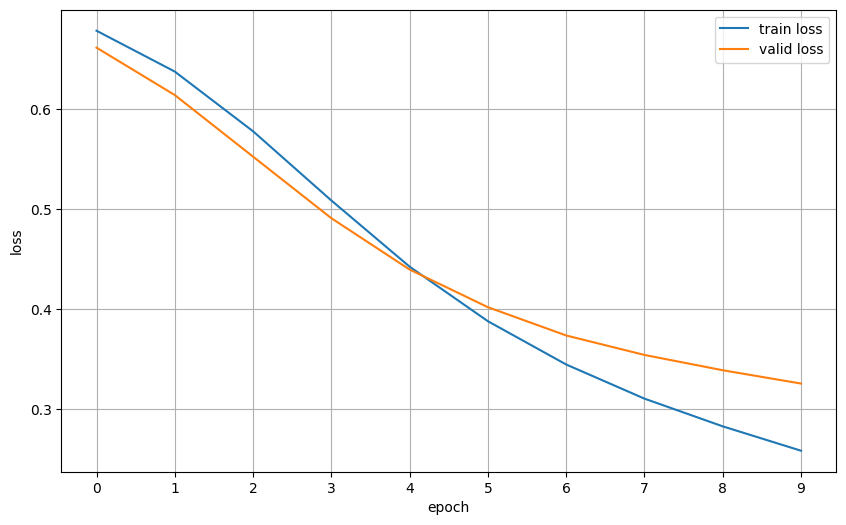

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

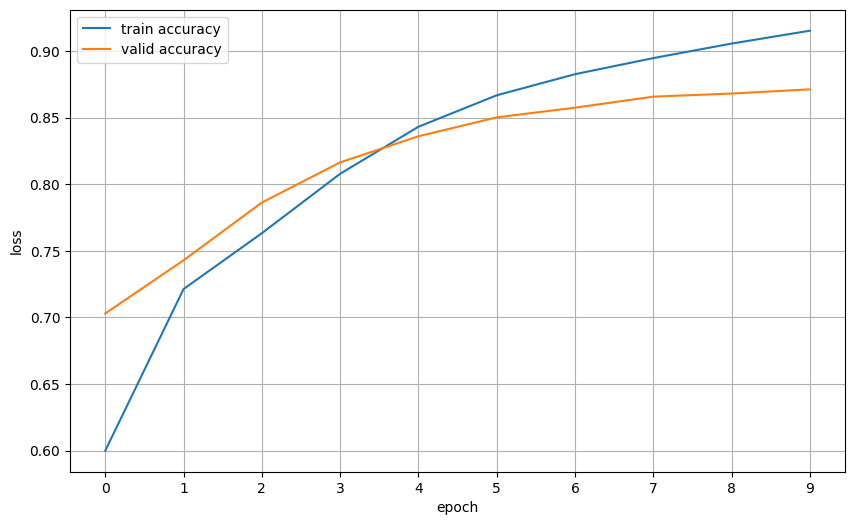

In [ ]:

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

Load best model and test on data

In [ ]:
model.load_state_dict(torch.load("nbow.pt"))
test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

evaluating...: 100%|██████████| 49/49 [00:08<00:00,  6.09it/s]

test_loss: 0.356, test_acc: 0.855


Now create a function for any text

In [ ]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    print(predicted_class, predicted_probability)

In [ ]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)


text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

0 0.9967615008354187
1 1.0
1 0.9749318361282349
1 0.9749318361282349


##RNNs

We need to load and tokenize our data a bit differently because we need to know the true sequence length as well.

In [ ]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

For the padding index the embedding will be set to zero. The RNN used here is an LSTM, we've stacked n_layers LSTMs on top of each other sequentially. Then passed through a fully connected layer.

The padded sequence is converted to a packed sequence object where length is the length of the true sequence, this is necessary to handle various lengths efficiently (i.e remove the paddings). Then we have the lstm outputs, the packed output must be translated back into a padded sequence.

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                n_layers, bidirectional, dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids)) # ids = [batch size, seq len]

        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # hidden = [n layers * n directions, batch size, hidden dim]

        # cell = [n layers * n directions, batch size, hidden dim]

        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [batch size, seq len, hidden dim * n directions]

        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))

            # hidden = [batch size, hidden dim * 2]

        else:
            hidden = self.dropout(hidden[-1])

            # hidden = [batch size, hidden dim]

        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]

        return prediction

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

output_dim
# model = LSTM(
#     vocab_size,
#     embedding_dim,
#     hidden_dim,
#     output_dim,
#     n_layers,
#     bidirectional,
#     dropout_rate,
#     pad_index,
# )

NameError: name 'vocab' is not defined

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

Use xavier initialisation for linear layers, initialise weight matrices to be orthogonal as thats good for addressing gradient problems especially for RNNs.

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

model.apply(initialize_weights)

Again use the glove embeddings and fine tune.

In [ ]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding

In [ ]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)

        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    print(np.mean(epoch_losses), np.mean(epoch_accs))
    return np.mean(epoch_losses), np.mean(epoch_accs)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy



In [ ]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

Now testing

In [ ]:
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

In [ ]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)


text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

##CNNs 1x1

Use the initial dataloaders (no need to encode length)

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes,
        output_dim, dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
            [nn.Conv1d(embedding_dim, n_filters, filter_size) for filter_size in filter_sizes] #Basically a small weighted average
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))

        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, embedding dim, seq len]

        conved = [torch.relu(conv(embedded)) for conv in self.convs]

        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]

        pooled = [conv.max(dim=-1).values for conv in conved]

        # pooled_n = [batch size, n filters]

        cat = self.dropout(torch.cat(pooled, dim=-1))

        # cat = [batch size, n filters * len(filter_sizes)]

        prediction = self.fc(cat)

        # prediction = [batch size, output dim]
        return prediction



vocab_size = len(vocab)
embedding_dim = 300
n_filters = 100
filter_sizes = [3, 5, 7]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.25

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

Use different initializations, kaiming for the conv.

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

model.apply(initialize_weights)

Again fine tune

In [ ]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding

lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

In [ ]:
model = model.to(device)
criterion = criterion.to(device)
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

Testing plotting

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
model.load_state_dict(torch.load("cnn.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

In [ ]:
def predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)


text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

##Transformers

We're not creating our own transformer, we are fine tuning a publicly available transformer, use the transformer library to import famous transformers

We will be using BERT. Now tokenizer is an object and is the same one used in BERT (word wise). It does everything automatically

In [ ]:
import transformers

transformer_name = "bert-base-uncased"

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

In [ ]:
tokenizer.tokenize("hello world!")

In [ ]:
tokenizer.encode("hello world!")

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("hello world"))

There are plenty of functions available with this tokenizer, check it out, its very simple, very easy to use and should be the go to for any NLP project.

In [ ]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["text"], truncation=True)["input_ids"]
    return {"ids": ids}

train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Inspect the training data tokenized

In [ ]:
train_data[0]

To check the id of any word

In [ ]:
tokenizer.vocab["!"]

Lets look at the pad token

In [ ]:
tokenizer.pad_token

In [ ]:
tokenizer.pad_token_id

In [ ]:
tokenizer.vocab[tokenizer.pad_token]

Loading data is similar, use a smaller batch size

In [ ]:
pad_index = tokenizer.pad_token_id

test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn


def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

So input goes into a transformer, comes out and is fed into a fc one linear layer (transformed) to an output straight away, no activation.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]

        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction


#Choose the transformer

transformer = transformers.AutoModel.from_pretrained(transformer_name)

In [ ]:
transformer.config.hidden_size

Do not freeze the transformer, we are fine tuning it

In [ ]:
output_dim = len(train_data["label"].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

In [ ]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
n_epochs = 3
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

Transformers are leagues above in accuracy. The other 3 give marginal gains. Attention is OP.

Testing and plotting

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability


text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)


text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)